# Petri Net Discovery: Sequencial & Loop & Parallel Workflow Patterns

## Step 1: Setup

In [1]:
import pandas as pd
import pm4py
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.util import dataframe_utils
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.visualization.petri_net import visualizer as pn_visualizer

## Step 2: Load Event Log from CSV

In [2]:
df = pd.read_csv("2d_toy_log_day11-sequential-loop-parallel-choice-more.csv", sep=';',parse_dates=["timestamp"])
df.head()

,timestamp,location,day,report_case_id,simpler_event_type
0,09/05/2025 08:52,home,09/05/2025,1,self-report_high
1,09/05/2025 13:36,other,09/05/2025,3,physical_activity_START
2,09/05/2025 13:48,other,09/05/2025,3,physical_activity_END
3,09/05/2025 13:55,other,09/05/2025,3,physical_activity_START
4,09/05/2025 13:58,other,09/05/2025,3,physical_activity_END


## Step 3: Prepare the Event Log
PM4Py expects specific column names. Let's rename them and sort the log by time within each case.

In [3]:
# Rename columns to PM4Py convention
df = df.rename(columns={
    "timestamp": "time:timestamp",
    "report_case_id": "case:concept:name",
    "simpler_event_type": "concept:name"
})

# Sort by case and time
df = dataframe_utils.convert_timestamp_columns_in_df(df)
df = df.sort_values(by=["case:concept:name", "time:timestamp"])
#df['case:concept:name'] = df['case:concept:name'].dt.strftime('%Y-%m-%d')

# Ensure concept:name is string type
df['concept:name'] = df['concept:name'].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   time:timestamp     43 non-null     datetime64[ns, UTC]
 1   location           43 non-null     object             
 2   day                43 non-null     datetime64[ns, UTC]
 3   case:concept:name  43 non-null     int64              
 4   concept:name       43 non-null     object             
dtypes: datetime64[ns, UTC](2), int64(1), object(2)
memory usage: 1.8+ KB


## Step 4: Convert to PM4Py Event Log

In [4]:
from pm4py.objects.conversion.log import converter as log_converter

event_log = log_converter.apply(df, variant=log_converter.Variants.TO_EVENT_LOG)

## Step 5: Discover the Process Tree Using Inductive Miner

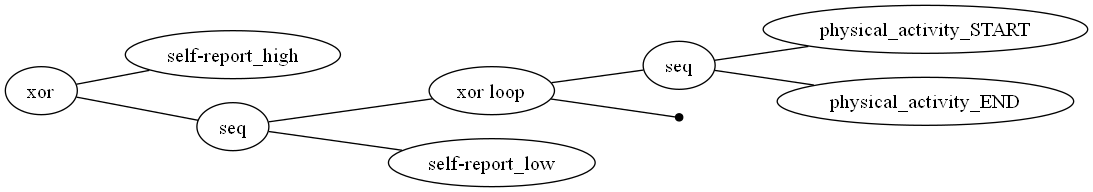

In [5]:
## Discover Process Model
# First get the process tree
process_tree = inductive_miner.apply(event_log)

# Visualize Process Tree
from pm4py.visualization.process_tree import visualizer as pt_visualizer
gviz_pt = pt_visualizer.apply(process_tree)
pt_visualizer.view(gviz_pt)



## Step 6: Converting to Petri Net

In [6]:
# Convert process tree to Petri net
from pm4py.objects.conversion.process_tree import converter as pt_converter
net, initial_marking, final_marking = pt_converter.apply(process_tree)

## Step 7: Visualizing the Petri Net

Simple Petri Net 

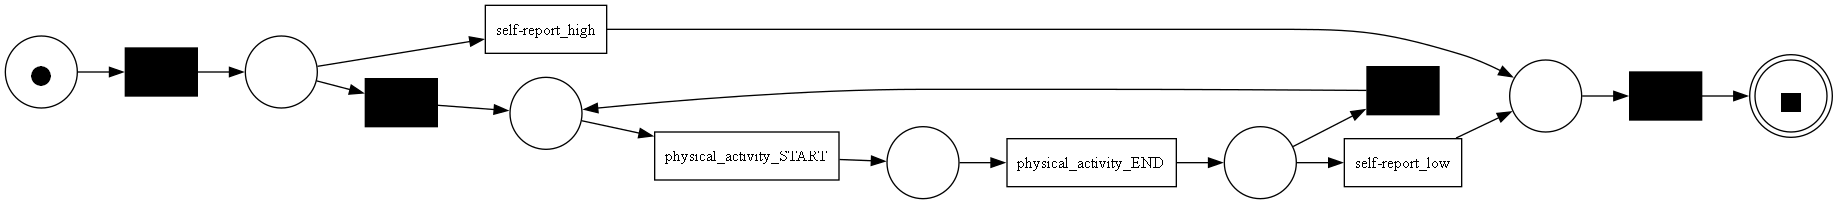

In [7]:
gviz = pn_visualizer.apply(net, initial_marking, final_marking, 
                          log=event_log)
pn_visualizer.view(gviz)

Petri Net with frequency statistics

replaying log with TBR, completed traces ::   0%|          | 0/5 [00:00<?, ?it/s]

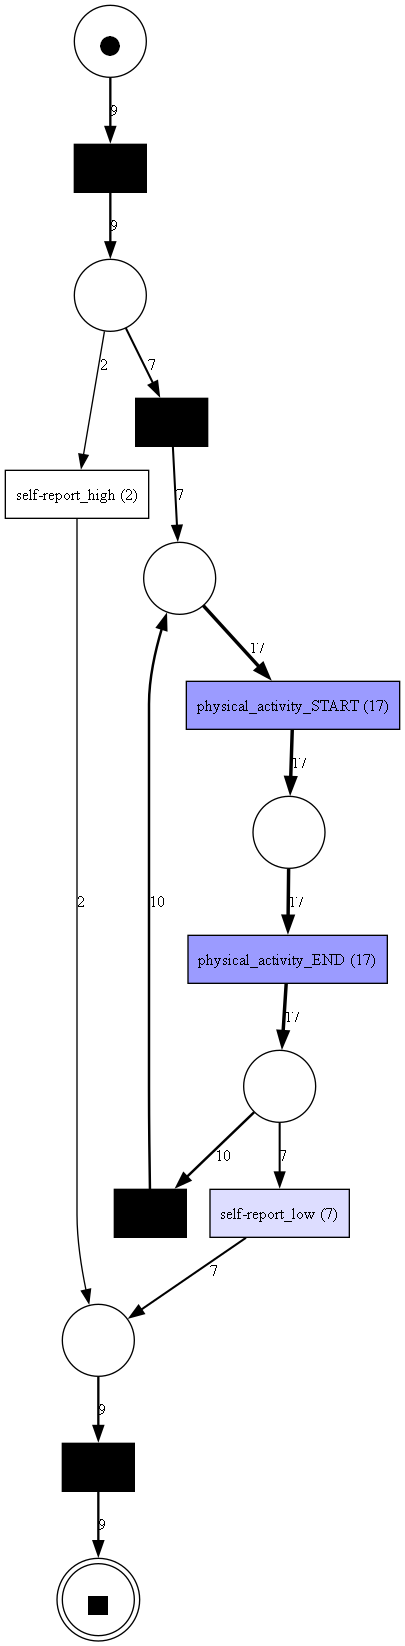

In [8]:
# Visualizing
# For frequency-based visualization
parameters = {
    pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png",
    pn_visualizer.Variants.FREQUENCY.value.Parameters.DEBUG: False,
    pn_visualizer.Variants.FREQUENCY.value.Parameters.RANKDIR: "TB"
}
gviz = pn_visualizer.apply(net, initial_marking, final_marking, 
                          variant=pn_visualizer.Variants.FREQUENCY,
                          parameters=parameters,
                          log=event_log)
pn_visualizer.view(gviz)

Petri net with time statistics

replaying log with TBR, completed traces ::   0%|          | 0/5 [00:00<?, ?it/s]

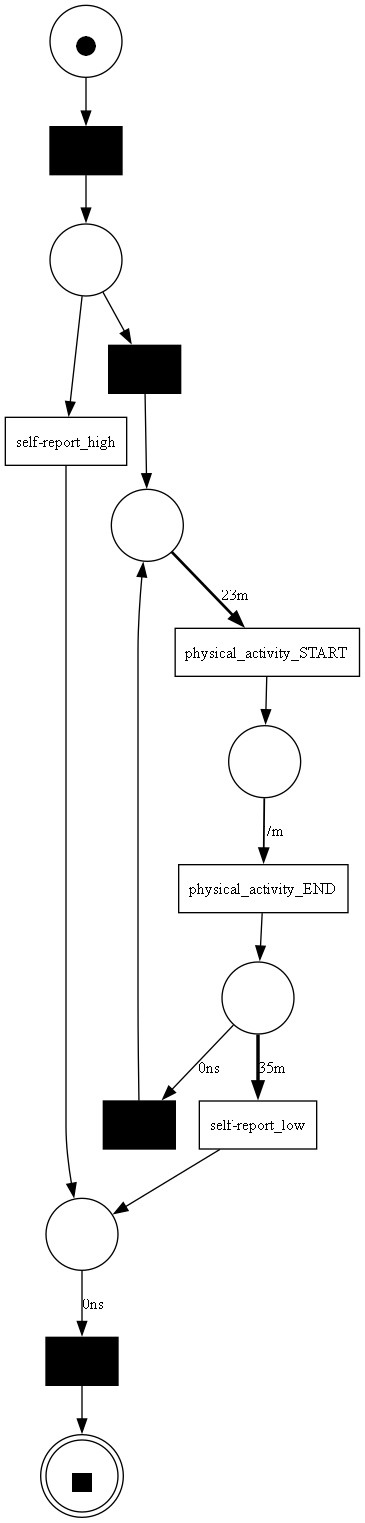

In [9]:
# Convert process tree to Petri net
# For performance-based visualization (showing time statistics)
# Convert timestamps if they're not in datetime format
if isinstance(event_log[0][0]['time:timestamp'], str):
    for trace in event_log:
        for event in trace:
            event['time:timestamp'] = pd.to_datetime(event['time:timestamp'])


parameters = {
    pn_visualizer.Variants.PERFORMANCE.value.Parameters.FORMAT: "png",
    pn_visualizer.Variants.PERFORMANCE.value.Parameters.DEBUG: False,
    pn_visualizer.Variants.PERFORMANCE.value.Parameters.RANKDIR: "TB",
    pn_visualizer.Variants.PERFORMANCE.value.Parameters.AGGREGATION_MEASURE: "mean",  # or "median", "min", "max"
    pn_visualizer.Variants.PERFORMANCE.value.Parameters.ACTIVITY_KEY: "concept:name",
    pn_visualizer.Variants.PERFORMANCE.value.Parameters.TIMESTAMP_KEY: "time:timestamp"
}
gviz = pn_visualizer.apply(net, initial_marking, final_marking, 
                          variant=pn_visualizer.Variants.PERFORMANCE,
                          parameters=parameters,
                          log=event_log)
pn_visualizer.view(gviz)

## Data Aware Mining

In [10]:
# Initialize the miner (as before)
import sys
sys.path.append('..')
from src.data_aware_mining import DataAwareProcessMining
miner = DataAwareProcessMining(net, initial_marking, final_marking, event_log)
print(event_log)

[{'attributes': {'concept:name': 1}, 'events': [{'time:timestamp': Timestamp('2025-09-05 08:52:00+0000', tz='UTC'), 'location': 'home', 'day': Timestamp('2025-09-05 00:00:00+0000', tz='UTC'), 'concept:name': 'self-report_high'}]}, '....', {'attributes': {'concept:name': 22}, 'events': [{'time:timestamp': Timestamp('2025-05-13 08:45:00+0000', tz='UTC'), 'location': 'home', 'day': Timestamp('2025-05-13 00:00:00+0000', tz='UTC'), 'concept:name': 'self-report_high'}]}]


In [11]:
# First detect choice points
choice_points = miner.detect_choice_points()
miner.get_choice_point_names()
choice_points


=== Detecting Choice Points ===
All transitions in net:
  - tau_1 (label: None)
  - tau_2 (label: None)
  - 1baaa618-9a58-4aa9-b182-6e37fb323afd (label: self-report_high)
  - a38d0ce7-3f42-4fcc-9b87-949f1e8bf5fa (label: physical_activity_START)
  - 2180b266-a5db-4f30-b349-83355335a5b5 (label: self-report_low)
  - init_loop_3 (label: None)
  - e7f442d3-cd36-4eff-98fa-6257876296a4 (label: physical_activity_END)
  - skip_5 (label: None)

All places in net:
  - source
    Outgoing arcs:
      -> tau_1 (label: None)
    Incoming arcs:
  - p_3
    Outgoing arcs:
      -> 1baaa618-9a58-4aa9-b182-6e37fb323afd (label: self-report_high)
      -> init_loop_3 (label: None)
    Incoming arcs:
      <- tau_1 (label: None)
  - p_7
    Outgoing arcs:
      -> skip_5 (label: None)
      -> 2180b266-a5db-4f30-b349-83355335a5b5 (label: self-report_low)
    Incoming arcs:
      <- e7f442d3-cd36-4eff-98fa-6257876296a4 (label: physical_activity_END)
  - p_8
    Outgoing arcs:
      -> e7f442d3-cd36-4eff-98

In [12]:
# First see what transitions and labels you have
miner.print_transition_labels()


Current transition labels in net:
Transition: tau_1
  Label: (no label)
Transition: tau_2
  Label: (no label)
Transition: 1baaa618-9a58-4aa9-b182-6e37fb323afd
  Label: self-report_high
Transition: a38d0ce7-3f42-4fcc-9b87-949f1e8bf5fa
  Label: physical_activity_START
Transition: 2180b266-a5db-4f30-b349-83355335a5b5
  Label: self-report_low
Transition: init_loop_3
  Label: (no label)
Transition: e7f442d3-cd36-4eff-98fa-6257876296a4
  Label: physical_activity_END
Transition: skip_5
  Label: (no label)


In [13]:
# Then modify labels as needed
miner.set_transition_label('init_loop_3', 'physical_activity_START')
# Check the changes
miner.print_transition_labels()

Set label 'physical_activity_START' for transition init_loop_3

Current transition labels in net:
Transition: tau_1
  Label: (no label)
Transition: tau_2
  Label: (no label)
Transition: 1baaa618-9a58-4aa9-b182-6e37fb323afd
  Label: self-report_high
Transition: a38d0ce7-3f42-4fcc-9b87-949f1e8bf5fa
  Label: physical_activity_START
Transition: 2180b266-a5db-4f30-b349-83355335a5b5
  Label: self-report_low
Transition: init_loop_3
  Label: physical_activity_START
Transition: e7f442d3-cd36-4eff-98fa-6257876296a4
  Label: physical_activity_END
Transition: skip_5
  Label: (no label)


In [14]:
# Mine a decision tree for a specific choice point
# For example, if you have a place named "p1" and want to use attributes "age" and "priority"
result = miner.mine_decision_tree(
    place_name="p_3",
    attributes=["location"],
    max_depth=2  # optional: limit tree depth
)


=== Mining Decision Tree ===
Place: p_3
Attributes: ['location']

Found 2 transitions for this choice point:
  - 1baaa618-9a58-4aa9-b182-6e37fb323afd (label: self-report_high)
  - init_loop_3 (label: physical_activity_START)

=== Finding Traces for Choice Point ===
Looking for traces at place: p_3
  Transition: 1baaa618-9a58-4aa9-b182-6e37fb323afd
    Label: self-report_high
  Transition: init_loop_3
    Label: physical_activity_START

Transitions that can be taken from this place (by label):
  - self-report_high (transition: 1baaa618-9a58-4aa9-b182-6e37fb323afd)
  - physical_activity_START (transition: init_loop_3)

Processing trace 1
Number of events: 1

  Checking event 0: self-report_high
    Found a transition from our place: 1baaa618-9a58-4aa9-b182-6e37fb323afd (label: self-report_high)
    Attribute location: home
    Single-event trace - using this transition

Processing trace 2
Number of events: 5

  Checking event 0: physical_activity_START
    Found a transition from our pl

In [15]:
# Get the decision rules in a readable format
rules = miner.get_decision_tree_rules("p_3")
print("Decision Rules:")
print(rules)

Decision Rules:
Decision Rules for p_3:

Attribute Encodings:

location:
  home -> 0
  other -> 1

Transition Encodings (by label):
  physical_activity_START -> 0
  self-report_high -> 1

Decision Tree Structure:
|--- location (home->0, other->1) <= 0.50
|   |--- class: self-report_high
|--- location (home->0, other->1) >  0.50
|   |--- class: physical_activity_START


Feature Importances:
  location: 1.000

Class Distribution:
  self-report_high: 2 samples (22.2%)
  physical_activity_START: 7 samples (77.8%)


In [16]:
# Get feature importances
importances = miner.get_feature_importances("p_3")
print("\nFeature Importances:")
for attr, importance in importances.items():
    print(f"{attr}: {importance:.3f}")

# Make a prediction for a new case
prediction = miner.predict_transition(
    place_name="p_3",
    state={
        "location": "home"	
    }
)
print(f"\nPredicted transition: {prediction}")


Feature Importances:
location: 1.000

Prediction details:
Input state: {'location': 'home'}
Encoded features:
  location: home -> 0

Predicted transition: self-report_high
Transition probabilities:
  physical_activity_START: 0.333
  self-report_high: 0.667

Predicted transition: self-report_high


In [17]:
# For each transition you want to label
for trans in net.transitions:
    if trans.name == 'init_loop_3':
        trans.label = 'physical_activity_START /  @home; p=0.333'
    if trans.label == 'self-report_high':
        trans.label = 'self-report_high /  @home; p=0.667'

replaying log with TBR, completed traces ::   0%|          | 0/5 [00:00<?, ?it/s]

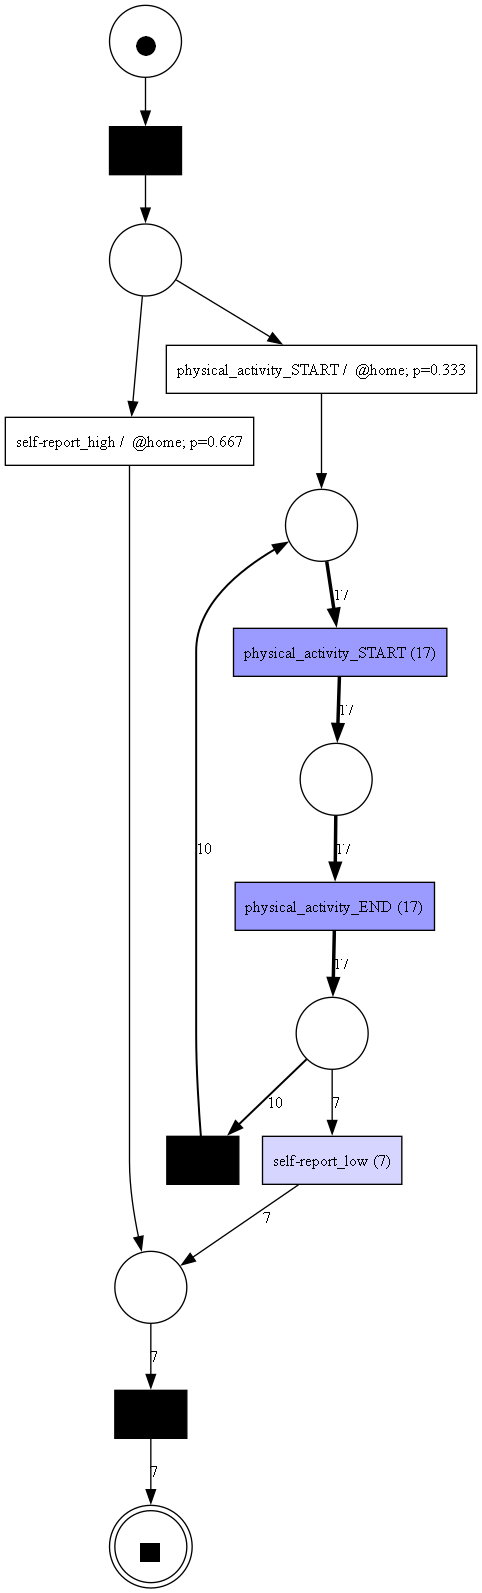

In [18]:
# Visualizing
# For frequency-based visualization
parameters = {
    pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png",
    pn_visualizer.Variants.FREQUENCY.value.Parameters.DEBUG: False,
    pn_visualizer.Variants.FREQUENCY.value.Parameters.RANKDIR: "TB"
}
gviz = pn_visualizer.apply(net, initial_marking, final_marking, 
                          variant=pn_visualizer.Variants.FREQUENCY,
                          parameters=parameters,
                          log=event_log)
pn_visualizer.view(gviz)